# 9.Maintenance

In [614]:
def calcul_maintenance(df, echant, nb_clusters):
    df_tmp = df.loc[df["Recency"] >= echant].copy()

    # Standardisation (pas d'encodage car que des floats sont présents dans dataframe
    std_scaled = preprocessing.StandardScaler()
    df_tmp_scaled, std_scaled = standardisation(df_tmp, std_scaled)

    # cluster_kmeanspp(df, nb_clusters)
    kmspp = cluster_kmeanspp(df_tmp_scaled, nb_clusters)

    # intégration des clusters dans la df d'origine avant transformation
    df_tmp["cluster_rfm_sim_kmpp"] = kmspp.labels_
    df_tmp["cluster_rfm_sim_kmpp"] = df_tmp["cluster_rfm_sim_kmpp"].astype("object")

    df_tmp.rename(columns={"cluster_rfm_sim_kmpp": echant}, inplace=True)

    return df_tmp

## <a name="C91">9.1 RFM</a>

### <a name="C911">9.1.1 Selection des colonnes</a>

In [615]:
# Sauvegarde de df_rfm
df_rfm_2 = df_rfm[["Recency", "Frequency", "Monetary", "cluster_rfm_kmpp"]].copy()
df_rfm_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96667 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Recency           96667 non-null  float64
 1   Frequency         96667 non-null  float64
 2   Monetary          96667 non-null  float64
 3   cluster_rfm_kmpp  96667 non-null  object 
dtypes: float64(3), object(1)
memory usage: 5.7+ MB


In [616]:
# Récupération des colonnes utiles
df_rfm_sim = df_rfm_2[["Recency", "Frequency", "Monetary"]].copy()
df_rfm_sim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96667 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    96667 non-null  float64
 1   Frequency  96667 non-null  float64
 2   Monetary   96667 non-null  float64
dtypes: float64(3)
memory usage: 5.0+ MB


In [617]:
# Achats de 2016 to 2018 : 2 ans = environ 730 jours

# Derniers clients
print(df_rfm_2["Recency"].min())
# Premiers clients
print(df_rfm_2["Recency"].max())

0.0
713.0


### <a name="C912">9.1.2 Stabilité clusters</a>

Nous avons X de forme (96667, 3)
ARI SCORE 0
1.0
Nous avons X de forme (96636, 3)
ARI SCORE 1
0.9976537209484412
Nous avons X de forme (96571, 3)
ARI SCORE 2
0.22379964368362112
Nous avons X de forme (96497, 3)
ARI SCORE 3
0.9820549211014097
Nous avons X de forme (96428, 3)
ARI SCORE 4
0.22367034497935204
Nous avons X de forme (96351, 3)
ARI SCORE 5
0.22360901969965502
Nous avons X de forme (96231, 3)
ARI SCORE 6
0.992494551174666
Nous avons X de forme (96059, 3)
ARI SCORE 7
0.9747797465116733
Nous avons X de forme (95826, 3)
ARI SCORE 8
0.9889599758909879
Nous avons X de forme (95545, 3)
ARI SCORE 9
0.22254619771145873
Nous avons X de forme (95302, 3)
ARI SCORE 10
0.9514250388864592
Nous avons X de forme (95103, 3)
ARI SCORE 11
0.9428320017950848
Nous avons X de forme (94897, 3)
ARI SCORE 12
0.9437087984393285
Nous avons X de forme (94602, 3)
ARI SCORE 13
0.9367388695931232
Nous avons X de forme (94261, 3)
ARI SCORE 14
0.9138751596882457
Nous avons X de forme (93970, 3)
ARI SCORE 15
0

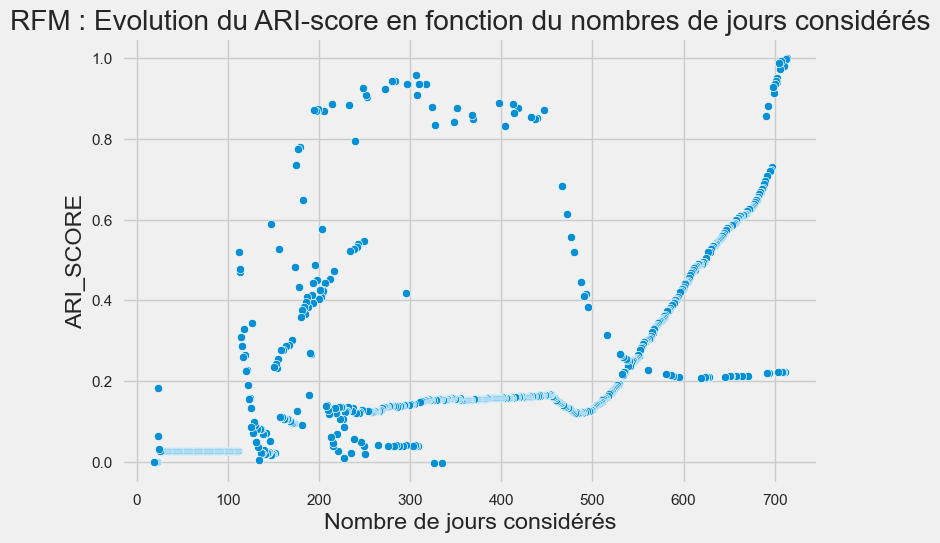

In [618]:
# echant=91
# i=echant
nb_clusters = 3
echant = 0

# Valeur du découpage
i = 1

# Initialisation de la liste pour stocker "echant"
liste = []

# Création d'un dataframe pour stocker les scores
ari_score = pd.DataFrame(columns=["Nombre de jours considérés", "ARI_SCORE"])
j = 0

# Création d'une condition au niveau du nombre de lignes pour éviter que nb_cluster soit supérieurs au nombre de ligne dans la df
df_tmp2 = df_rfm_sim.loc[df_rfm_sim["Recency"] >= echant].copy()

while echant <= df_rfm_2["Recency"].max() and len(df_tmp2) >= nb_clusters:
    df_tmp = calcul_maintenance(df_rfm_sim, echant, nb_clusters)
    df_rfm_2 = pd.merge(
        df_rfm_2,
        df_tmp[echant],
        left_on="customer_id",
        right_on="customer_id",
        how="left",
    )

    # Calcul du ARI score : d'abord supression des NaN
    df_ari = df_rfm_2.dropna(axis=0)
    print("ARI SCORE", df_ari[echant].name)
    print(metrics.adjusted_rand_score(df_ari["cluster_rfm_kmpp"], df_ari[echant]))

    # Enregistrement des scores dans la dataframes ari_scores
    ari_score.loc[j] = [
        df_rfm_2["Recency"].max() - echant,
        metrics.adjusted_rand_score(df_ari["cluster_rfm_kmpp"], df_ari[echant]),
    ]
    j += 1

    liste.append(echant)
    echant = echant + i
    df_tmp2 = df_rfm_sim.loc[df_rfm_sim["Recency"] >= echant].copy()


sns.scatterplot(
    data=ari_score, x="Nombre de jours considérés", y="ARI_SCORE", marker="o"
).set(title="RFM : Evolution du ARI-score en fonction du nombres de jours considérés")
ari_score.head(12)

fig = px.scatter(ari_score, x="Nombre de jours considérés", y="ARI_SCORE", title="RFM")
fig.show(renderer="browser")

[Text(0.5, 1.0, 'RFM : Evolution du ARI-score en fonction du nombres de jours considérés')]

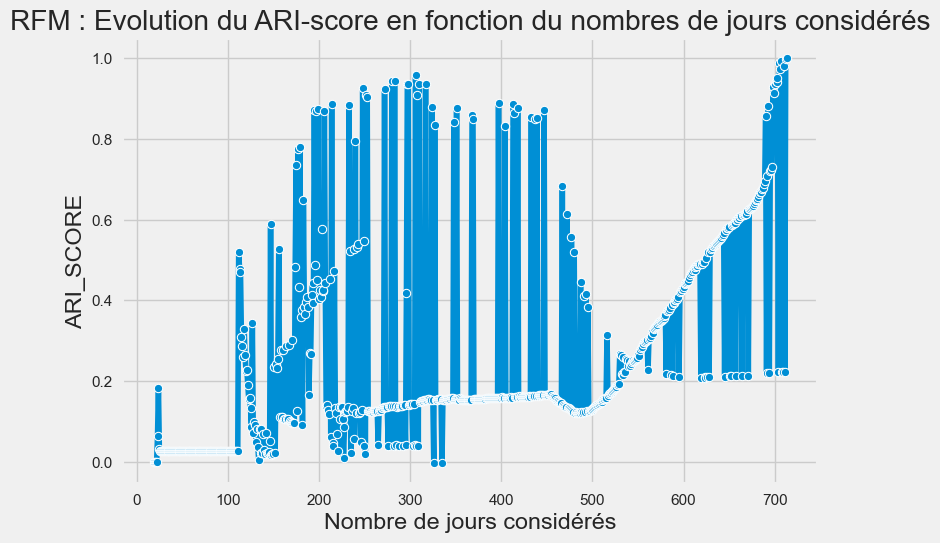

In [619]:
sns.lineplot(
    data=ari_score, x="Nombre de jours considérés", y="ARI_SCORE", marker="o"
).set(title="RFM : Evolution du ARI-score en fonction du nombres de jours considérés")

In [620]:
df_rfm_2.head()

,Recency,Frequency,Monetary,cluster_rfm_kmpp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,469.0,1.0,146.87,0,0,0,0,1,0,0,1,1,2,0,0,1,0,1,0,1,2,2,2,0,2,1,1,0,1,1,1,2,2,2,1,1,0,1,2,1,0,2,1,0,0,0,1,1,0,2,0,1,1,0,1,1,1,0,2,2,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,2,1,0,1,2,2,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,1,0,2,1,1,0,0,0,0,1,2,0,2,1,0,1,0,2,1,2,0,1,2,1,1,1,0,1,0,0,0,2,0,1,1,2,2,0,0,2,1,0,1,0,0,0,2,2,2,0,1,0,0,0,1,1,1,0,0,2,2,2,0,0,0,1,0,2,0,1,1,2,0,1,1,0,0,0,1,1,1,1,2,1,2,2,1,1,1,2,0,2,1,0,0,0,0,1,1,1,2,2,0,0,0,2,0,2,1,0,2,0,0,0,1,0,0,0,1,0,2,0,1,0,2,1,0,1,0,0,1,1,1,2,1,0,1,2,2,0,1,1,1,0,1,0,1,0,0,1,0,1,0,1,

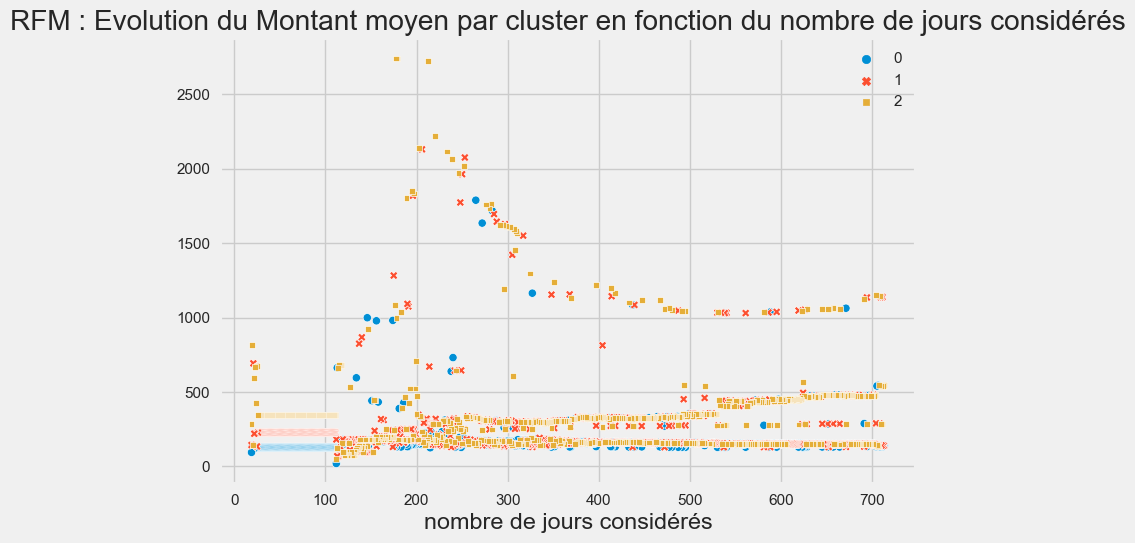

In [621]:
df_mean_final = pd.DataFrame()

# liste=range(echant)
for x in liste:
    df_mean = df_rfm_2.groupby(x)["Monetary"].mean()
    df_mean = pd.DataFrame(df_mean)
    df_mean.rename(columns={"Monetary": x}, inplace=True)

    # On ajoute les valeurs dans une dataframe
    df_mean_final = pd.concat([df_mean_final, df_mean], axis=1, ignore_index=False)

# On transpose
df_mean_final = df_mean_final.T


# Changons la nature de l'axe des abscisses pour montrer le nombre de jours considérés au lieu du nombre de jour non supprimés
df_mean_final_tmp = df_mean_final.copy()
df_mean_final_tmp["nombre de jours considérés"] = (
    df_rfm_2["Recency"].max() - df_mean_final.index
)
df_mean_final_tmp.set_index("nombre de jours considérés", inplace=True)
df_mean_final_tmp.head()

sns.scatterplot(data=df_mean_final_tmp).set(
    title="RFM : Evolution du Montant moyen par cluster en fonction du nombre de jours considérés"
)

fig = px.scatter(
    df_mean_final_tmp,
    title="RFM : Evolution du Montant moyen par cluster en fonction du nombre de jours considérés",
)
fig.show(renderer="browser")

[Text(0.5, 1.0, 'RFM : Evolution du Montant moyen par cluster en fonction du nombre de jours considérés')]

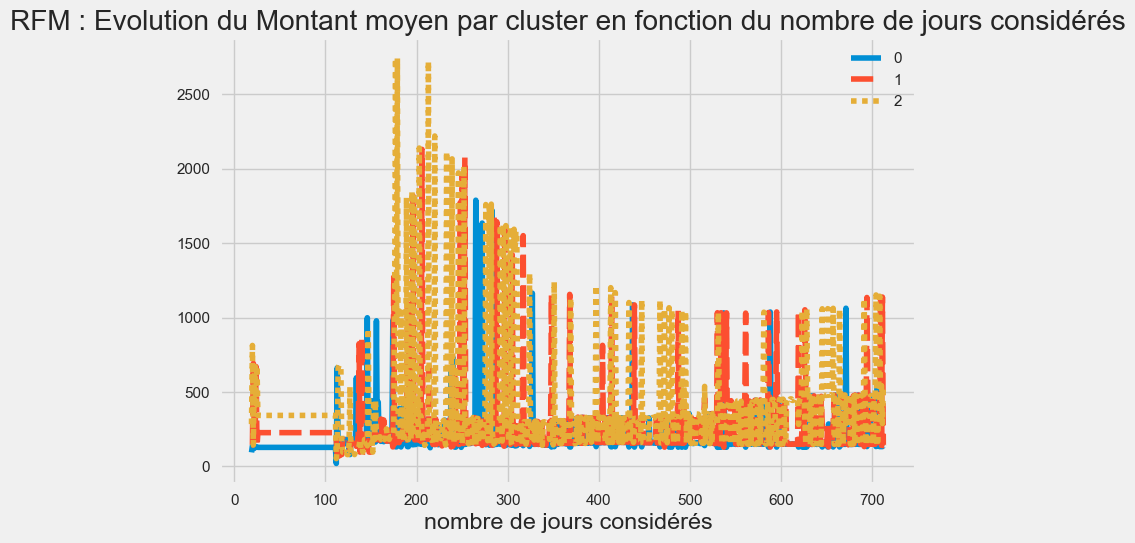

In [622]:
sns.lineplot(data=df_mean_final_tmp).set(
    title="RFM : Evolution du Montant moyen par cluster en fonction du nombre de jours considérés"
)

## <a name="C92">9.2 RFMER</a>

### <a name="C921">9.2.1 Selection des colonnes</a>

In [623]:
df_rfmer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95815 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             95815 non-null  float64
 1   Frequency           95815 non-null  float64
 2   Monetary            95815 non-null  float64
 3   review_score        95815 non-null  float64
 4   retard_livraison    95815 non-null  float64
 5   cluster_rfmer_kmpp  95815 non-null  object 
dtypes: float64(5), object(1)
memory usage: 7.1+ MB


In [624]:
# Sauvegarde de df_rfm
df_rfmer_2 = df_rfmer[
    [
        "Recency",
        "Frequency",
        "Monetary",
        "review_score",
        "retard_livraison",
        "cluster_rfmer_kmpp",
    ]
].copy()
df_rfmer_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95815 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             95815 non-null  float64
 1   Frequency           95815 non-null  float64
 2   Monetary            95815 non-null  float64
 3   review_score        95815 non-null  float64
 4   retard_livraison    95815 non-null  float64
 5   cluster_rfmer_kmpp  95815 non-null  object 
dtypes: float64(5), object(1)
memory usage: 7.1+ MB


In [625]:
# Récupération des colonnes utiles
df_rfmer_sim = df_rfmer_2[
    ["Recency", "Frequency", "Monetary", "review_score", "retard_livraison"]
].copy()
df_rfmer_sim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95815 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Recency           95815 non-null  float64
 1   Frequency         95815 non-null  float64
 2   Monetary          95815 non-null  float64
 3   review_score      95815 non-null  float64
 4   retard_livraison  95815 non-null  float64
dtypes: float64(5)
memory usage: 6.4+ MB


In [626]:
# Achats de 2016 to 2018 : 2 ans = environ 730 jours

# Derniers clients
print(df_rfmer_2["Recency"].min())
# Premiers clients
print(df_rfmer_2["Recency"].max())

0.0
713.0


### <a name="C922">9.2.2 Stabilité clusters</a>

Nous avons X de forme (95815, 5)
ARI SCORE 0
1.0
Nous avons X de forme (95784, 5)
ARI SCORE 1
0.5638779597035943
Nous avons X de forme (95720, 5)
ARI SCORE 2
0.606860152520765
Nous avons X de forme (95648, 5)
ARI SCORE 3
0.9424260315907238
Nous avons X de forme (95580, 5)
ARI SCORE 4
0.9859220224626967
Nous avons X de forme (95503, 5)
ARI SCORE 5
0.9472370845923274
Nous avons X de forme (95383, 5)
ARI SCORE 6
0.6415028503443635
Nous avons X de forme (95211, 5)
ARI SCORE 7
0.903038300770643
Nous avons X de forme (94978, 5)
ARI SCORE 8
0.6406552846607217
Nous avons X de forme (94700, 5)
ARI SCORE 9
0.5637624734306136
Nous avons X de forme (94458, 5)
ARI SCORE 10
0.5604717923938329
Nous avons X de forme (94261, 5)
ARI SCORE 11
0.6195100138890587
Nous avons X de forme (94056, 5)
ARI SCORE 12
0.5693684861649978
Nous avons X de forme (93763, 5)
ARI SCORE 13
0.631999590186661
Nous avons X de forme (93426, 5)
ARI SCORE 14
0.632997417570374
Nous avons X de forme (93139, 5)
ARI SCORE 15
0.634931

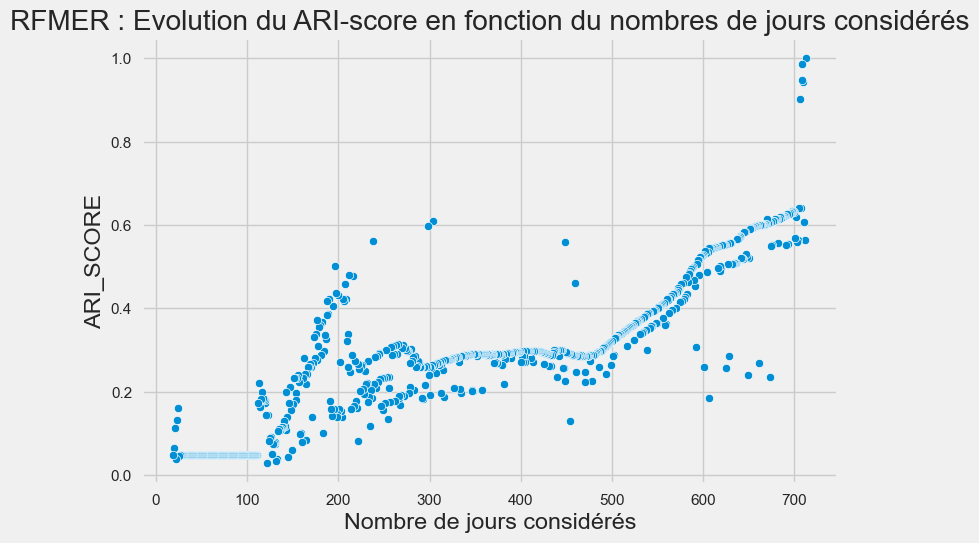

In [627]:
# echant=91
# i=echant
nb_clusters = 5
echant = 0

# Valeur du découpage
i = 1

# Initialisation de la liste pour stocker "echant"
liste = []

# Création d'un dataframe pour stocker les scores
ari_score = pd.DataFrame(columns=["Nombre de jours considérés", "ARI_SCORE"])
j = 0

# Création d'une condition au niveau du nombre de lignes pour éviter que nb_cluster soit supérieurs au nombre de ligne dans la df
df_tmp2 = df_rfmer_sim.loc[df_rfmer_sim["Recency"] >= echant].copy()

while echant <= df_rfmer_2["Recency"].max() and len(df_tmp2) >= nb_clusters:
    df_tmp = calcul_maintenance(df_rfmer_sim, echant, nb_clusters)
    df_rfmer_2 = pd.merge(
        df_rfmer_2,
        df_tmp[echant],
        left_on="customer_id",
        right_on="customer_id",
        how="left",
    )

    # Calcul du ARI score : d'abord supression des NaN
    df_ari = df_rfmer_2.dropna(axis=0)
    print("ARI SCORE", df_ari[echant].name)
    print(metrics.adjusted_rand_score(df_ari["cluster_rfmer_kmpp"], df_ari[echant]))

    # Enregistrement des scores dans la dataframes ari_scores
    ari_score.loc[j] = [
        df_rfmer_2["Recency"].max() - echant,
        metrics.adjusted_rand_score(df_ari["cluster_rfmer_kmpp"], df_ari[echant]),
    ]
    j += 1

    liste.append(echant)
    echant = echant + i
    df_tmp2 = df_rfmer_sim.loc[df_rfmer_sim["Recency"] >= echant].copy()

sns.scatterplot(
    data=ari_score, x="Nombre de jours considérés", y="ARI_SCORE", marker="o"
).set(title="RFMER : Evolution du ARI-score en fonction du nombres de jours considérés")
ari_score.head(12)

fig = px.scatter(
    ari_score, x="Nombre de jours considérés", y="ARI_SCORE", title="RFMER"
)
fig.show(renderer="browser")

[Text(0.5, 1.0, 'RFMER : Evolution du ARI-score en fonction du nombres de jours considérés')]

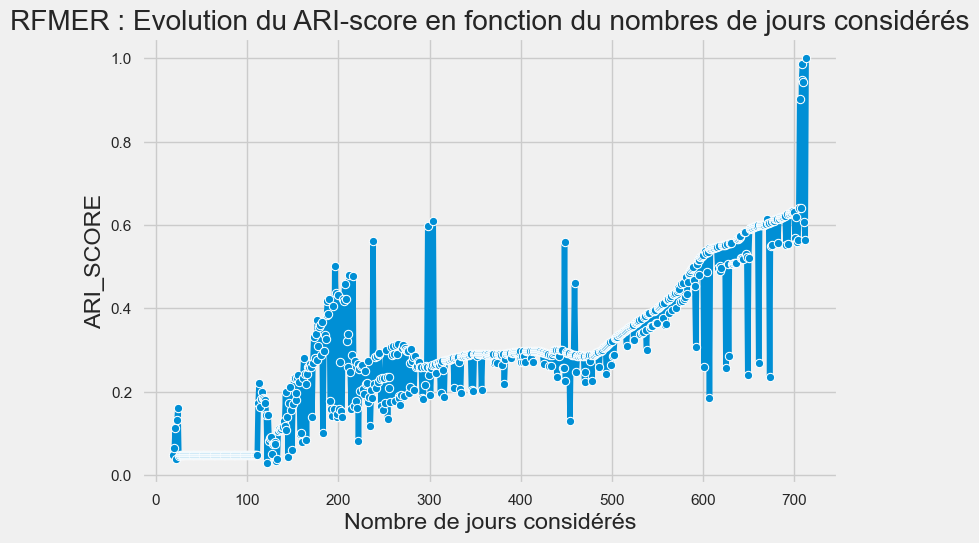

In [628]:
sns.lineplot(
    data=ari_score, x="Nombre de jours considérés", y="ARI_SCORE", marker="o"
).set(title="RFMER : Evolution du ARI-score en fonction du nombres de jours considérés")

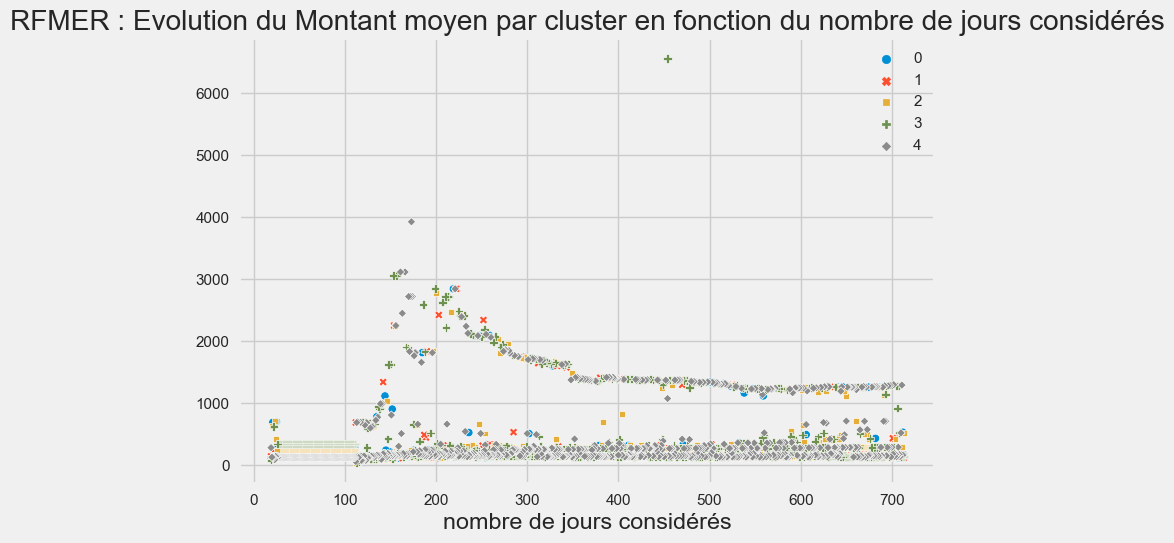

In [629]:
df_mean_final = pd.DataFrame()

# liste=range(echant)
for x in liste:
    df_mean = df_rfmer_2.groupby(x)["Monetary"].mean()
    df_mean = pd.DataFrame(df_mean)
    df_mean.rename(columns={"Monetary": x}, inplace=True)

    # On ajoute les valeurs dans une dataframe
    df_mean_final = pd.concat([df_mean_final, df_mean], axis=1, ignore_index=False)

# On transpose
df_mean_final = df_mean_final.T


# Changons la nature de l'axe des abscisses pour montrer le nombre de jours considérés au lieu du nombre de jour non supprimés
df_mean_final_tmp = df_mean_final.copy()
df_mean_final_tmp["nombre de jours considérés"] = (
    df_rfm_2["Recency"].max() - df_mean_final.index
)
df_mean_final_tmp.set_index("nombre de jours considérés", inplace=True)
df_mean_final_tmp.head()

sns.scatterplot(data=df_mean_final_tmp).set(
    title="RFMER : Evolution du Montant moyen par cluster en fonction du nombre de jours considérés"
)

fig = px.scatter(
    df_mean_final_tmp,
    title="RFMER : Evolution du Montant moyen par cluster en fonction du nombre de jours considérés",
)
fig.show(renderer="browser")

[Text(0.5, 1.0, 'RFMER : Evolution du Montant moyen par cluster en fonction du nombre de jours considérés')]

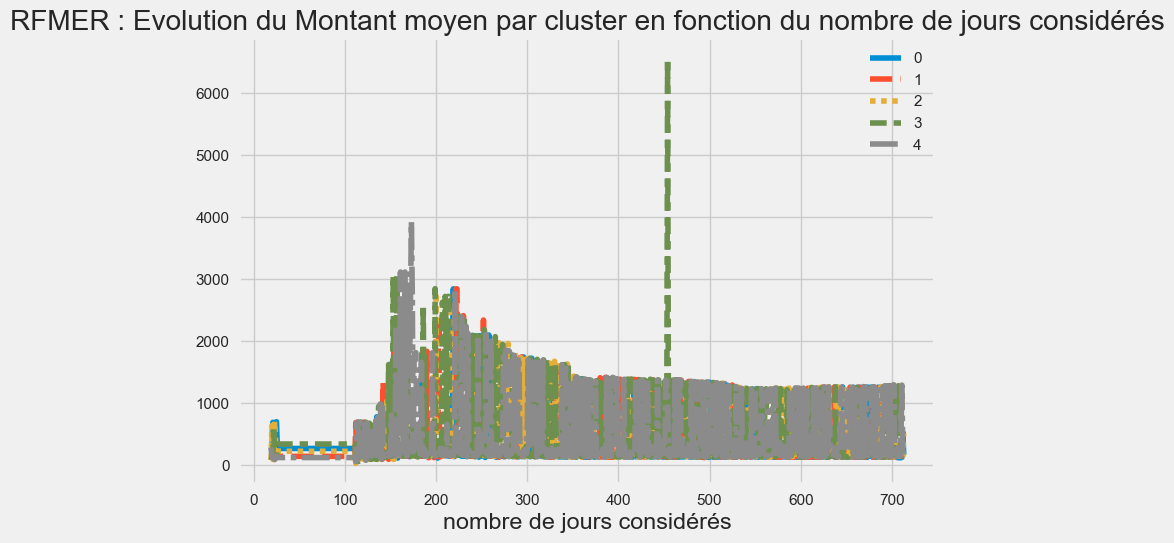

In [630]:
sns.lineplot(data=df_mean_final_tmp).set(
    title="RFMER : Evolution du Montant moyen par cluster en fonction du nombre de jours considérés"
)

# FIN

In [631]:
liste

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
